<a href="https://colab.research.google.com/github/Anya232536/study_hse/blob/main/bass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pysd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%pylab inline
import pysd
#model = pysd.read_vensim('./bass.MDL')

Populating the interactive namespace from numpy and matplotlib


In [ ]:
model = pysd.load('/content/bass_end.py')

In [ ]:
values = model.run()
values[['total market', 'Potential Customers', 'Customers_comp', 'Customers_cl', 'part_cl', 'part_comp']]

,total market,Potential Customers,Customers_comp,Customers_cl,part_cl,part_comp
time,,,,,,
0.00,100000.0,100000.000000,0.000000,0.000000,0.000000,0.000000
0.04,100000.0,99912.000000,44.000000,44.000000,0.000440,0.000440
0.08,100000.0,99822.820573,88.529826,88.649601,0.000886,0.000885
0.12,100000.0,99732.448878,133.594282,133.956840,0.001340,0.001336
0.16,100000.0,99640.872023,179.198172,179.929805,0.001799,0.001792
...,...,...,...,...,...,...
199.84,100000.0,22521.465544,4825.929211,72652.605245,0.726526,0.048259
199.88,100000.0,22521.464466,4825.920260,72652.615274,0.726526,0.048259
199.92,100000.0,22521.463389,4825.911325,72652.625285,0.726526,0.048259


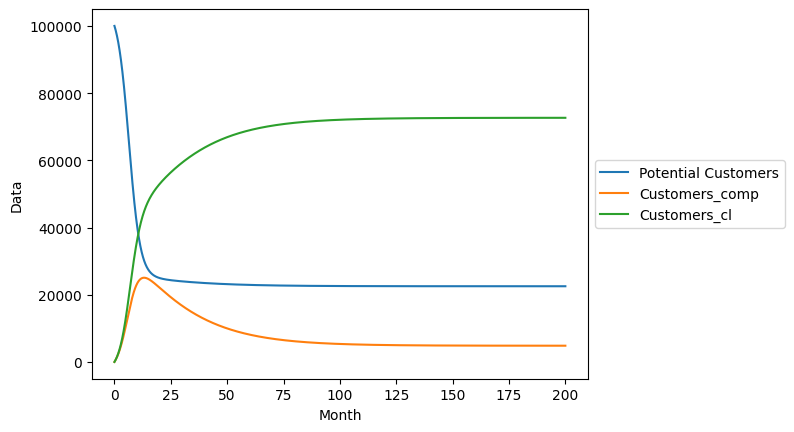

In [ ]:
values = model.run(return_columns=['Potential Customers', 'Customers_comp', 'Customers_cl'])
values.plot()
plt.ylabel('Data')
plt.xlabel('Month')
plt.legend(loc='center left', bbox_to_anchor=(1,.5));

Видно, что модель стабилизируется

Часть 2. Предъявляю время, значение метрики (cheсk), а также доли, в тот момент, когда модель сошлась.

Выбранная метрика: $|part.cl_{i-5} -part.cl_i| + |part.comp_{i-5} -part.comp_i| < eps$

$eps = 0.00025$

Метрика выбрана опираясь на определения равномерной сходимости, я запоминаю назад на 5 шагов m = 5.

Сама функция прописана в модели, при достижение нуобходимого уровня метрики, модель выдает stop, иначе continue.

In [ ]:
results = model.run(return_columns=['part_cl', 'part_comp', 'check', 'flag'])
results[results['flag']=='stop'].iloc[0]

,80.92
part_cl,0.712398
part_comp,0.060867
check,0.0002
flag,stop


График сходимости

<ipython-input-49-2550d6c11c3f>:2: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  plt.plot(range(len(results['check'][2:len(results)])), results['check'][2:len(results)], color='r')


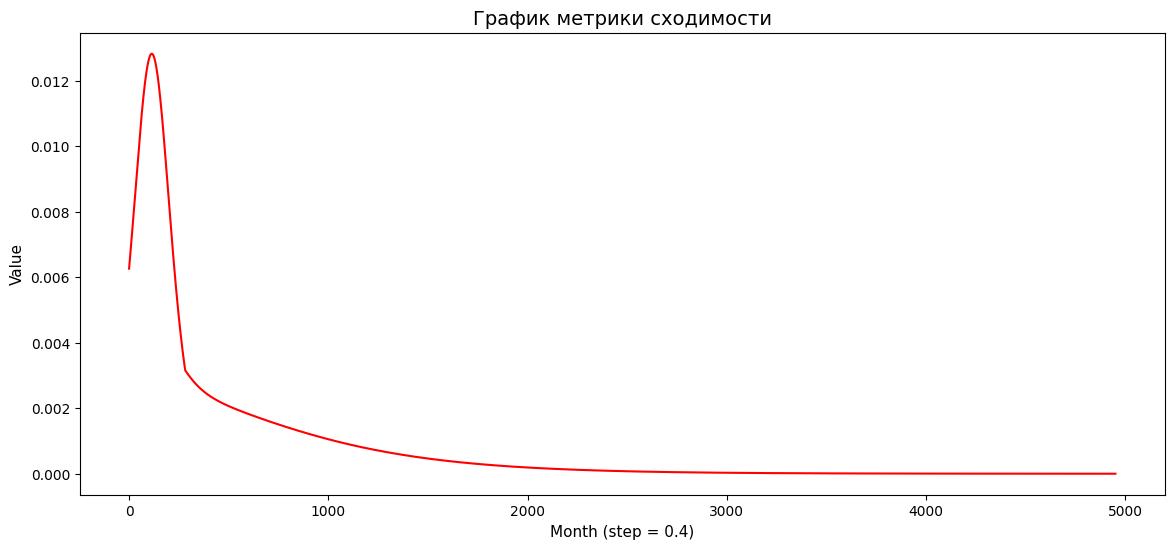

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(range(len(results['check'][2:len(results)])), results['check'][2:len(results)], color='r')
plt.xlabel('Month (step = 0.4)', fontsize=11)
plt.ylabel('Value', fontsize=11)
plt.title('График метрики сходимости', fontsize=14)
plt.show()


Полученное значение M, которое мы фиксируем

In [ ]:
#значение M, которое получили на 1 шаге, от него дальше действуем
M = float(results['part_cl'].iloc[len(results)-1])
M

0.7265264524995505

Берем точки по сетке для обучения ML модели, прогоняем их через модель и таким образом получаем долю рынка

In [ ]:
import numpy as np

def generate(p11=None, p13=None, p21=0.33, p23=0.4):
    if any([p11 == None, p13 == None]):
        p11 = np.random.uniform()
        p13 = np.random.uniform(0, 1 - p11)

    values = model.run(params={'p11':p11, 'p13':p13, 'p21':p21, 'p23':p23},
                       return_columns=['p11', 'p13', 'p21', 'p23', 'part_cl', 'part_comp', 'flag']).iloc[-1]
    return values

In [ ]:
from tqdm import tqdm

df_list = []


for i in range(2000):
  tmp = generate()
  df_list.append(tmp)

df = pd.DataFrame(df_list).reset_index(drop=True)
df = df[df['flag'] == 'stop'].reset_index(drop=True) #убираем, где модель не сошлась
df

/usr/local/lib/python3.11/dist-packages/pysd/py_backend/model.py:1140: UserWarning: Replacing a variable by a constant value.
  warnings.warn("Replacing a variable by a constant value.")


,p11,p13,p21,p23,part_cl,part_comp,flag
0,0.233697,0.556805,0.33,0.4,0.023582,0.648187,stop
1,0.591024,0.277761,0.33,0.4,0.864797,0.005600,stop
2,0.422269,0.028096,0.33,0.4,0.980479,0.001118,stop
3,0.228457,0.439507,0.33,0.4,0.030435,0.643158,stop
4,0.444448,0.014488,0.33,0.4,0.990487,0.000496,stop
...,...,...,...,...,...,...,...
1991,0.599989,0.352655,0.33,0.4,0.830868,0.007250,stop
1992,0.877820,0.017878,0.33,0.4,0.994214,0.000122,stop
1993,0.230987,0.456759,0.33,0.4,0.029599,0.643649,stop
1994,0.264263,0.664702,0.33,0.4,0.022627,0.647512,stop


Выбираем и обучаем прямую модель, то есть по p11 и p22 будем предсказывать M

In [ ]:
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split
import xgboost

In [ ]:
y = df['part_cl'].copy()
X = df[['p11', 'p13']].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Попробуем линейную модель с ридж-регуляризацией и бустинг

In [ ]:
ln = Ridge(alpha = 10)
ln.fit(X_train, y_train)
y_train_pred = ln.predict(X_train)
y_test_pred = ln.predict(X_test)

In [ ]:
RMSE = metrics.mean_squared_error(y_test, y_test_pred)
R2 = metrics.r2_score(np.array(y_test), y_test_pred)
print("RMSE ridge=", RMSE)
print("R2 ridge=", R2)

RMSE ridge= 0.03807371487560817
R2 ridge= 0.7669274833792241


In [ ]:
bst = xgboost.XGBRegressor(n_estimators=300, max_depth=12, learning_rate=0.01)
bst.fit(X_train, y_train)
y_train_pred = bst.predict(X_train)
y_test_pred = bst.predict(X_test)

In [ ]:
RMSE = metrics.mean_squared_error(y_test, y_test_pred)
R2 = metrics.r2_score(np.array(y_test), y_test_pred)
print("RMSE boost=", RMSE)
print("R2 boost=", R2)

RMSE boost= 0.0008829690077267027
R2 boost= 0.9945948061700474


Бустинг работает лучше, дальше будем использовать его


C помощью ML модели генерим новые M, здесь просто сэмплируем новые точки, без сетки, так как будто бы гораздо быстрее

In [ ]:
test_new = df.iloc[0:1][['p11', 'p13']].copy()
test_new['indexes'] = 10**6
sample = test_new.loc[test_new.index.repeat(test_new.indexes)].reset_index(drop=True)
sample['p11'] = df.iloc[0]['p11']*np.random.uniform(0, 1/df.iloc[0]['p11'], size=10**6)
sample['p13'] = np.random.uniform(0, 1-sample['p11'])
sample.drop(columns='indexes', inplace=True)
pred = bst.predict(sample)
sample['pred'] = pred
sample

,p11,p13,pred
0,0.003734,0.568265,0.044492
1,0.399749,0.365822,0.717131
2,0.690225,0.135674,0.931543
3,0.066325,0.808998,0.044492
4,0.005013,0.687913,0.044492
...,...,...,...
999995,0.693063,0.043952,0.966627
999996,0.482078,0.393737,0.754748
999997,0.299978,0.177524,0.781496
999998,0.718008,0.063272,0.960987


In [ ]:
#количество точек, которые дали предсказание в интервале [0.93M; 1.07M]
s = sample[(sample['pred']>=0.93*M) & (sample['pred']<=1.07*M)]
s

,p11,p13,pred
1,0.399749,0.365822,0.717131
27,0.371719,0.290866,0.736595
50,0.549257,0.427050,0.771711
58,0.440230,0.337223,0.759916
60,0.487709,0.360454,0.774522
...,...,...,...
999923,0.458447,0.374738,0.749579
999926,0.398312,0.349242,0.734648
999988,0.335907,0.263170,0.757545
999996,0.482078,0.393737,0.754748


Фактически уже сейчас можно построить траекторию, просто интерполировать точки (p11 и p13), которые дали результат близкий к M (лежащий в интервале [0.93M; 1.07M]).

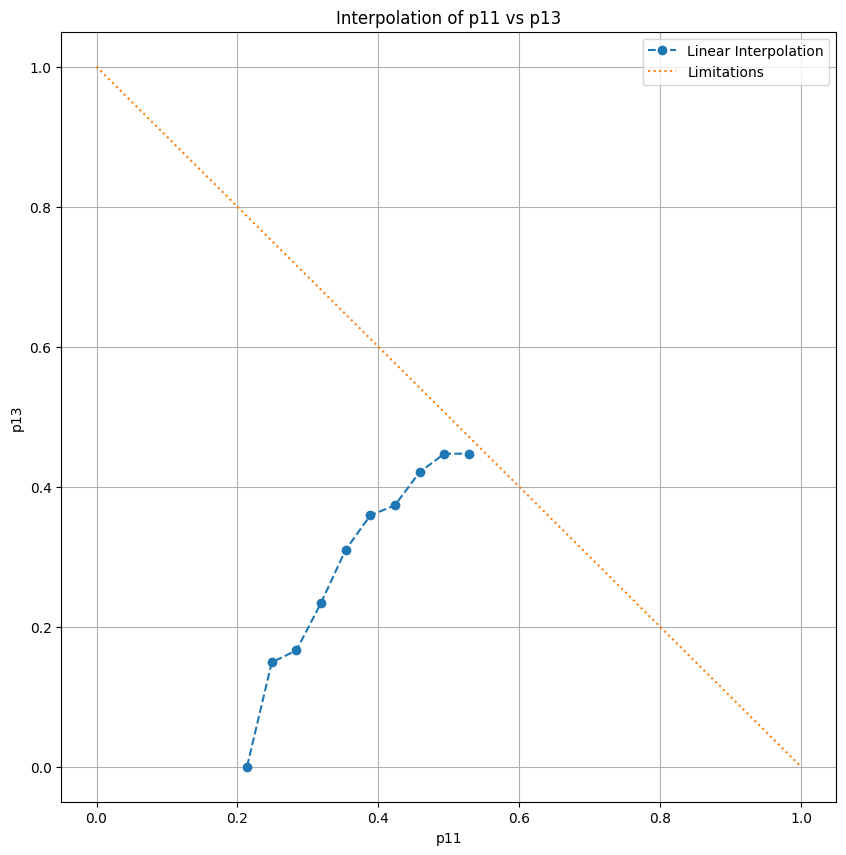

In [ ]:
from scipy.interpolate import interp1d
n = 10

linear_interp = interp1d(np.array(s['p11']), np.array(s['p13']), kind='linear')
x_new = np.linspace(np.array(s['p11']).min(), np.array(s['p13']).max(), num=n, endpoint=True)
y_linear = linear_interp(x_new)

plt.figure(figsize=(10, 10))
plt.grid()
plt.plot(x_new, y_linear, label='Linear Interpolation', linestyle='--', marker='o')
plt.plot([0, 1], [1, 0], label='Limitations', linestyle='dotted')

plt.xlabel('p11')
plt.ylabel('p13')
plt.legend()
plt.title('Interpolation of p11 vs p13')
plt.show()

Попробуем второй способ: обучаем обратную ML модель, учим модель на полученном датасете, но теперь хотим по полученным M предсказать (p11, p13).

In [ ]:
y_inverse = np.column_stack([s['p11'].to_numpy(), s['p13'].to_numpy()])
X_inverse = s['pred'].to_numpy()
X_train_inverse, X_test_inverse, y_train_inverse, y_test_inverse = train_test_split(X_inverse, y_inverse, test_size=0.3, random_state=42)



In [ ]:
inverse_model = xgboost.XGBRegressor(n_estimators=3000, max_depth=6, learning_rate=0.001)

inverse_model.fit(X_train_inverse.reshape(-1, 1), y_train_inverse)  # M — вход, p11, p22 — выход

y_pred_inverse = inverse_model.predict(X_test_inverse.reshape(-1, 1))

RMSE = metrics.mean_squared_error(y_test_inverse, y_pred_inverse)
R2 = metrics.r2_score(np.array(y_test_inverse), y_pred_inverse)

print('RMSE обратной модели', RMSE)
print('R2 обратной модели', R2)

#очень низкая точность у бустинга

RMSE обратной модели 0.005330620257486143
R2 обратной модели 0.4156046898146662


In [ ]:
#попробую перебрать параметры, чтобы найти наилучшую модель
!pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Integer, Real

param_space = {
    'n_estimators': Integer(50, 1000),
    'max_depth': Integer(5, 20),
    'min_samples_leaf': Integer(1, 15),
    'lambda': Integer(1, 3),
    'learning_rate': Real(0.001, 0.01)
}

inv_model = xgboost.XGBRegressor()
bayes_search = BayesSearchCV(inv_model, param_space, n_iter=50, cv=3)
bayes_search.fit(X_train_inverse.reshape(-1, 1), y_train_inverse)

# Вывод наилучших гиперпараметров и оценки
print("Best Hyperparameters:", bayes_search.best_params_)
print("Best Cross-Validation Score:", bayes_search.best_score_)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.5 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:06:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:06:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:07:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:07:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:07:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "min_samples_lea

Best Hyperparameters: OrderedDict([('lambda', 1), ('learning_rate', 0.01), ('max_depth', 17), ('min_samples_leaf', 1), ('n_estimators', 1000)])
Best Cross-Validation Score: 0.5399778702180056


In [ ]:
# с лучшими параметрами

inverse_model = xgboost.XGBRegressor(n_estimators=1000, max_depth=17, learning_rate=0.01, random_state=42)

inverse_model.fit(X_train_inverse.reshape(-1, 1), y_train_inverse)  # M — вход, p11, p22 — выход

y_pred_inverse = inverse_model.predict(X_test_inverse.reshape(-1, 1))

RMSE = metrics.mean_squared_error(y_test_inverse, y_pred_inverse)
R2 = metrics.r2_score(np.array(y_test_inverse), y_pred_inverse)

print('RMSE обратной модели', RMSE)
print('R2 обратной модели', R2)
#ну в итоге все равно метрики так себе, поэтому попробую случайный лес вдруг будет лучше

RMSE обратной модели 0.0039028802592544418
R2 обратной модели 0.5686024367253644


In [ ]:
from sklearn.ensemble import RandomForestRegressor

inverse_model_forest = RandomForestRegressor(n_estimators=1000, max_depth=17, random_state=42)
inverse_model_forest.fit(X_train_inverse.reshape(-1, 1), y_train_inverse)

y_pred_inverse = inverse_model_forest.predict(X_test_inverse.reshape(-1, 1))

RMSE = metrics.mean_squared_error(y_test_inverse, y_pred_inverse)
R2 = metrics.r2_score(np.array(y_test_inverse), y_pred_inverse)

print('RMSE обратной модели', RMSE)
print('R2 обратной модели', R2)
#получу хорошие метрики, отлично! будет работать со случайным лесом

RMSE обратной модели 0.0003347146223312052
R2 обратной модели 0.9618323260085542


Предсказываем p11, p13 по обратной модели для подходящих нам M

In [ ]:
M_pred = np.linspace(0.93*M, 1.07*M, 3000)
y_pred_end = inverse_model_forest.predict(M_pred.reshape(-1, 1))
df_pred = pd.DataFrame(y_pred_end, columns=['p11', 'p13'])
df_pred["M"] = M_pred
df_pred

,p11,p13,M
0,0.427036,0.440586,0.675670
1,0.427036,0.440586,0.675704
2,0.427036,0.440586,0.675737
3,0.430492,0.447010,0.675771
4,0.430492,0.447010,0.675805
...,...,...,...
2995,0.321007,0.207369,0.777248
2996,0.321007,0.207369,0.777282
2997,0.399016,0.288522,0.777315
2998,0.542612,0.409914,0.777349


Получили нужные p11 и p13, теперь строим траекторию

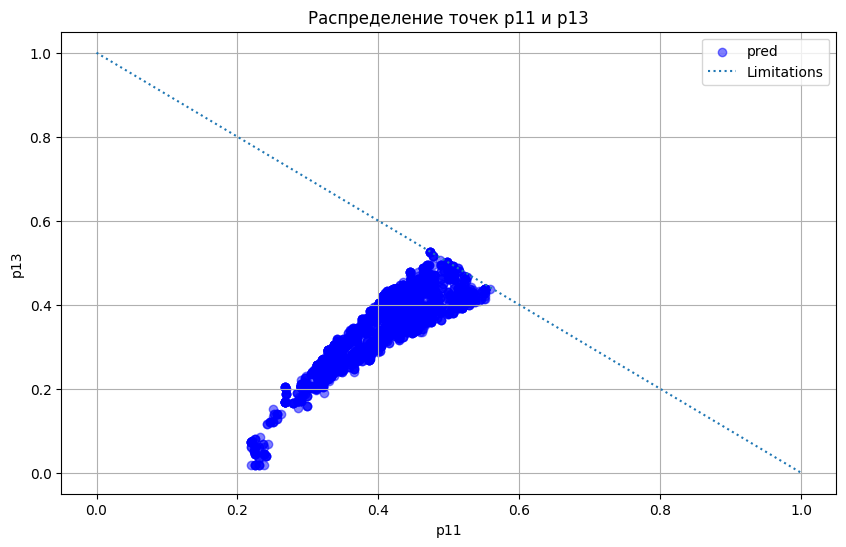

In [ ]:
from scipy.interpolate import interp1d
plt.figure(figsize=(10, 6))

# Строим точки p11 (по оси X) и p13 (по оси Y)
plt.scatter(df_pred["p11"], df_pred["p13"], alpha=0.5, color="blue", label="pred")
plt.plot([0, 1], [1, 0], label='Limitations', linestyle='dotted')

# Добавляем оформление
plt.xlabel("p11")
plt.ylabel("p13")
plt.title("Распределение точек p11 и p13")
plt.legend()
plt.grid(True)

# Показываем график
plt.show()


В целом данная область похожа на прямую, полученную интерполяцией

Аналитическая система уравнение и ее численное решение

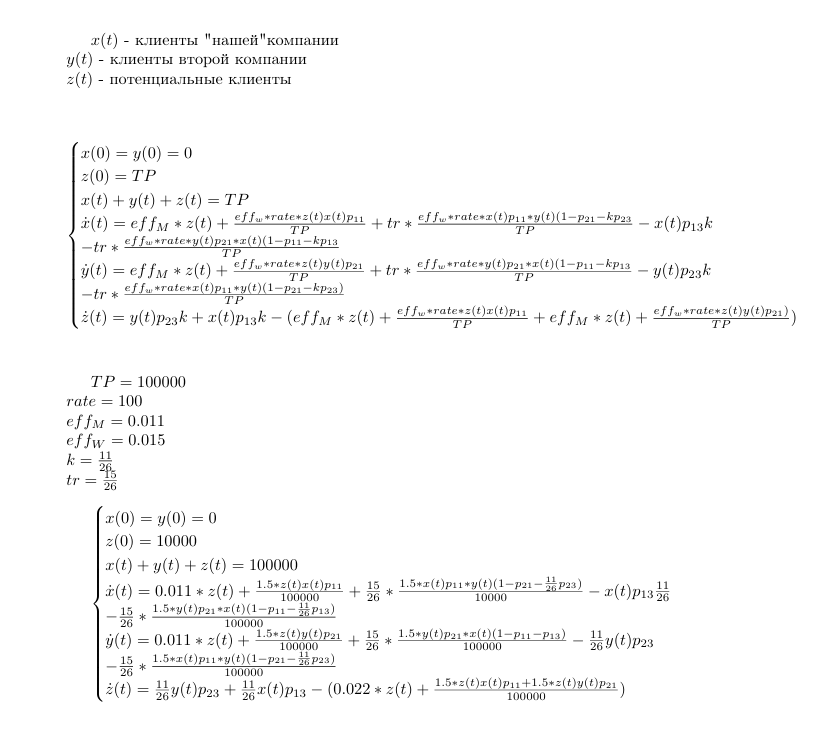

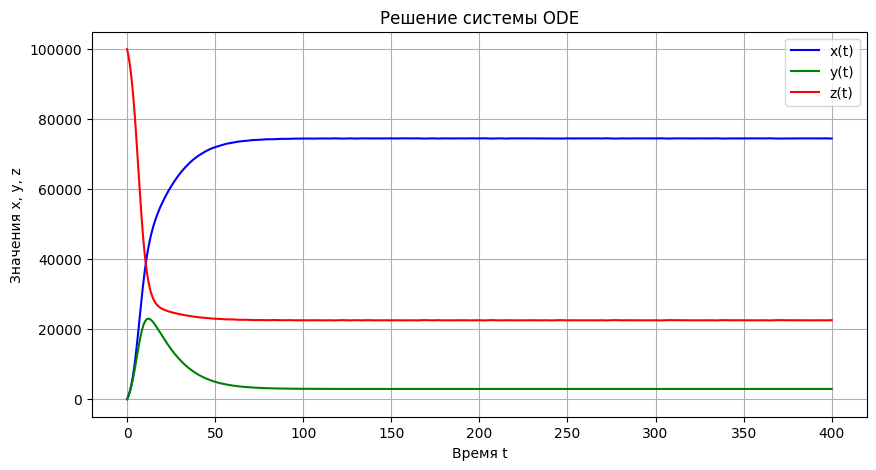

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

p11 = 0.34
p13 = 0.28
p21 = 0.32
p23 = 0.37
TP = 100000


def system(t, vars):
    x, y = vars
    z = 100000 - x - y

    # Уравнения
    dxdt = (
        0.011 * z
        + (1.5 * z * x * p11) / 100000
        + (15 / 26) * (1.5 * x * p11 * y * (1 - p21 - (11 / 26) * p23)) / 100000
        - (x * p13 * (11 / 26))
        - (15 / 26) * (1.5 * y * p21 * x * (1 - p11 - (11 / 26) * p13)) / 100000
    )

    dydt = (
        0.011 * z
        + (1.5 * z * y * p21) / 100000
        + (15 / 26) * (1.5 * y * p21 * x * (1 - p11 - p13)) / TP
        - (11 / 26) * y * p23
        - (15 / 26) * (1.5 * x * p11 * y * (1 - p21 - (11 / 26) * p23)) / TP
    )

    return [dxdt, dydt]

x0, y0 = 0, 0
y_init = [x0, y0]
t_span = (0, 400)
t_eval = np.linspace(0, 400, 1000)


sol = solve_ivp(system, t_span, y_init, t_eval=t_eval, method="RK45")


t = sol.t
x = sol.y[0]
y = sol.y[1]
z = 100000 - x - y


plt.figure(figsize=(10, 5))
plt.plot(t, x, label="x(t)", color="blue")
plt.plot(t, y, label="y(t)", color="green")
plt.plot(t, z, label="z(t)", color="red")
plt.xlabel("Время t")
plt.ylabel("Значения x, y, z")
plt.title("Решение системы ODE")
plt.legend()
plt.grid()
plt.show()